<a href="https://colab.research.google.com/github/waltbt/ODE/blob/master/Basic_ODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up of basic modules
I don't know why, but you must first uninstall tensorflow, so that you can properly install tensorflow-gpu or there will be errors.

In [1]:
!pip install pyDOE # I believe this is only used for the latin hypercube random selection

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=54a8d5558cc98a0869e2675a86deab0d96ed6bc7a0976ca9d5cd46e30c90c880
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


# Optional GPU Support

In [2]:
# !pip uninstall tensorflow -y
# !pip install tensorflow-gpu 
# !pip install pyDOE # I believe this is only used for the latin hypercube random selection

# Set up

In [3]:
import sys
import os
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp

# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

# Logger and Data Prep

In [4]:
import scipy.io
import numpy as np
import tensorflow as tf
import time
from datetime import datetime
from pyDOE import lhs
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# "." for Colab/VSCode, and ".." for GitHub
repoPath = os.path.join(".", "PINNs")
# repoPath = os.path.join("..", "PINNs")
utilsPath = os.path.join(repoPath, "Utilities")
dataPath = os.path.join(repoPath, "main", "Data")
appDataPath = os.path.join(repoPath, "appendix", "Data")

# sys.path.insert(0, utilsPath)
# from plotting import newfig, savefig

def prep_data(path, N_u=None, N_f=None, N_n=None, q=None, ub=None, lb=None, noise=0.0, idx_t_0=None, idx_t_1=None, N_0=None, N_1=None):
    # Reading external data [t is 100x1, usol is 256x100 (solution), x is 256x1]
    data = scipy.io.loadmat(path)

    # Flatten makes [[]] into [], [:,None] makes it a column vector
    t = data['t'].flatten()[:,None] # T x 1
    x = data['x'].flatten()[:,None] # N x 1

    # Keeping the 2D data for the solution data (real() is maybe to make it float by default, in case of zeroes)
    Exact_u = np.real(data['usol']).T # T x N

    if N_n != None and q != None and ub != None and lb != None and idx_t_0 != None and idx_t_1 != None:
      dt = t[idx_t_1] - t[idx_t_0]
      idx_x = np.random.choice(Exact_u.shape[1], N_n, replace=False) 
      x_0 = x[idx_x,:]
      u_0 = Exact_u[idx_t_0:idx_t_0+1,idx_x].T
      u_0 = u_0 + noise*np.std(u_0)*np.random.randn(u_0.shape[0], u_0.shape[1])
        
      # Boudanry data
      x_1 = np.vstack((lb, ub))
      
      # Test data
      x_star = x
      u_star = Exact_u[idx_t_1,:]

      # Load IRK weights
      tmp = np.float32(np.loadtxt(os.path.join(utilsPath, "IRK_weights", "Butcher_IRK%d.txt" % (q)), ndmin = 2))
      IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q))
      IRK_times = tmp[q**2+q:]

      return x, t, dt, Exact_u, x_0, u_0, x_1, x_star, u_star, IRK_weights, IRK_times

    # Meshing x and t in 2D (256,100)
    X, T = np.meshgrid(x,t)

    # Preparing the inputs x and t (meshed as X, T) for predictions in one single array, as X_star
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

    # Preparing the testing u_star
    u_star = Exact_u.flatten()[:,None]
                
    # Noiseless data TODO: add support for noisy data    
    idx = np.random.choice(X_star.shape[0], N_u, replace=False)
    X_u_train = X_star[idx,:]
    u_train = u_star[idx,:]

    if N_0 != None and N_1 != None:
      Exact_u = Exact_u.T
      idx_x = np.random.choice(Exact_u.shape[0], N_0, replace=False)
      x_0 = x[idx_x,:]
      u_0 = Exact_u[idx_x,idx_t_0][:,None]
      u_0 = u_0 + noise*np.std(u_0)*np.random.randn(u_0.shape[0], u_0.shape[1])
          
      idx_x = np.random.choice(Exact_u.shape[0], N_1, replace=False)
      x_1 = x[idx_x,:]
      u_1 = Exact_u[idx_x,idx_t_1][:,None]
      u_1 = u_1 + noise*np.std(u_1)*np.random.randn(u_1.shape[0], u_1.shape[1])
      
      dt = np.asscalar(t[idx_t_1] - t[idx_t_0])        
      q = int(np.ceil(0.5*np.log(np.finfo(float).eps)/np.log(dt)))

      # Load IRK weights
      tmp = np.float32(np.loadtxt(os.path.join(utilsPath, "IRK_weights", "Butcher_IRK%d.txt" % (q)), ndmin = 2))
      weights =  np.reshape(tmp[0:q**2+q], (q+1,q))     
      IRK_alpha = weights[0:-1,:]
      IRK_beta = weights[-1:,:] 
      return x_0, u_0, x_1, u_1, x, t, dt, q, Exact_u, IRK_alpha, IRK_beta

    if N_f == None:
      lb = X_star.min(axis=0)
      ub = X_star.max(axis=0) 
      return x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, ub, lb

    # Domain bounds (lowerbounds upperbounds) [x, t], which are here ([-1.0, 0.0] and [1.0, 1.0])
    lb = X_star.min(axis=0)
    ub = X_star.max(axis=0) 
    # Getting the initial conditions (t=0)
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    uu1 = Exact_u[0:1,:].T
    # Getting the lowest boundary conditions (x=-1) 
    xx2 = np.hstack((X[:,0:1], T[:,0:1]))
    uu2 = Exact_u[:,0:1]
    # Getting the highest boundary conditions (x=1) 
    xx3 = np.hstack((X[:,-1:], T[:,-1:]))
    uu3 = Exact_u[:,-1:]
    # Stacking them in multidimensional tensors for training (X_u_train is for now the continuous boundaries)
    X_u_train = np.vstack([xx1, xx2, xx3])
    u_train = np.vstack([uu1, uu2, uu3])

    # Generating the x and t collocation points for f, with each having a N_f size
    # We pointwise add and multiply to spread the LHS over the 2D domain
    X_f_train = lb + (ub-lb)*lhs(2, N_f)

    # Generating a uniform random sample from ints between 0, and the size of x_u_train, of size N_u (initial data size) and without replacement (unique)
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    # Getting the corresponding X_u_train (which is now scarce boundary/initial coordinates)
    X_u_train = X_u_train[idx,:]
    # Getting the corresponding u_train
    u_train = u_train [idx,:]

    return x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, X_f_train, ub, lb

class Logger(object):
  def __init__(self, frequency=10):
    print("TensorFlow version: {}".format(tf.__version__))
    print("Eager execution: {}".format(tf.executing_eagerly()))
    print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

    self.start_time = time.time()
    self.frequency = frequency

  def __get_elapsed(self):
    return datetime.fromtimestamp(time.time() - self.start_time).strftime("%M:%S")

  def __get_error_u(self):
    return self.error_fn()

  def set_error_fn(self, error_fn):
    self.error_fn = error_fn
  
  def log_train_start(self, model):
    print("\nTraining started")
    print("================")
    self.model = model
    print(self.model.summary())

  def log_train_epoch(self, epoch, loss, custom="", is_iter=False):
    if epoch % self.frequency == 0:
      print(f"{'nt_epoch' if is_iter else 'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4e}  error = {self.__get_error_u():.4e}  " + custom)

  def log_train_opt(self, name):
    # print(f"tf_epoch =      0  elapsed = 00:00  loss = 2.7391e-01  error = 9.0843e-01")
    print(f"—— Starting {name} optimization ——")

  def log_train_end(self, epoch, custom=""):
    print("==================")
    print(f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()}  error = {self.__get_error_u():.4e}  " + custom)



# A custom LBFGS optimizer

In [5]:
# Adapted from https://github.com/yaroslavvb/stuff/blob/master/eager_lbfgs/eager_lbfgs.py

import tensorflow as tf
import numpy as np
import time

# Time tracking functions
global_time_list = []
global_last_time = 0
def reset_time():
  global global_time_list, global_last_time
  global_time_list = []
  global_last_time = time.perf_counter()
  
def record_time():
  global global_last_time, global_time_list
  new_time = time.perf_counter()
  global_time_list.append(new_time - global_last_time)
  global_last_time = time.perf_counter()
  #print("step: %.2f"%(global_time_list[-1]*1000))

def last_time():
  """Returns last interval records in millis."""
  global global_last_time, global_time_list
  if global_time_list:
    return 1000 * global_time_list[-1]
  else:
    return 0

def dot(a, b):
  """Dot product function since TensorFlow doesn't have one."""
  return tf.reduce_sum(a*b)

def verbose_func(s):
  print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, config, state, do_verbose, log_fn):
  """port of lbfgs.lua, using TensorFlow eager mode.
  """

  if config.maxIter == 0:
    return

  global final_loss, times
  
  maxIter = config.maxIter
  maxEval = config.maxEval or maxIter*1.25
  tolFun = config.tolFun or 1e-5
  tolX = config.tolX or 1e-19
  nCorrection = config.nCorrection or 100
  lineSearch = config.lineSearch
  lineSearchOpts = config.lineSearchOptions
  learningRate = config.learningRate or 1
  isverbose = config.verbose or False

  # verbose function
  if isverbose:
    verbose = verbose_func
  else:
    verbose = lambda x: None

    # evaluate initial f(x) and df/dx
  f, g = opfunc(x)

  f_hist = [f]
  currentFuncEval = 1
  state.funcEval = state.funcEval + 1
  p = g.shape[0]

  # check optimality of initial point
  tmp1 = tf.abs(g)
  if tf.reduce_sum(tmp1) <= tolFun:
    verbose("optimality condition below tolFun")
    return x, f_hist

  # optimize for a max of maxIter iterations
  nIter = 0
  times = []
  while nIter < maxIter:
    start_time = time.time()
    
    # keep track of nb of iterations
    nIter = nIter + 1
    state.nIter = state.nIter + 1

    ############################################################
    ## compute gradient descent direction
    ############################################################
    if state.nIter == 1:
      d = -g
      old_dirs = []
      old_stps = []
      Hdiag = 1
    else:
      # do lbfgs update (update memory)
      y = g - g_old
      s = d*t
      ys = dot(y, s)
      
      if ys > 1e-10:
        # updating memory
        if len(old_dirs) == nCorrection:
          # shift history by one (limited-memory)
          del old_dirs[0]
          del old_stps[0]

        # store new direction/step
        old_dirs.append(s)
        old_stps.append(y)

        # update scale of initial Hessian approximation
        Hdiag = ys/dot(y, y)

      # compute the approximate (L-BFGS) inverse Hessian 
      # multiplied by the gradient
      k = len(old_dirs)

      # need to be accessed element-by-element, so don't re-type tensor:
      ro = [0]*nCorrection
      for i in range(k):
        ro[i] = 1/dot(old_stps[i], old_dirs[i])
        

      # iteration in L-BFGS loop collapsed to use just one buffer
      # need to be accessed element-by-element, so don't re-type tensor:
      al = [0]*nCorrection

      q = -g
      for i in range(k-1, -1, -1):
        al[i] = dot(old_dirs[i], q) * ro[i]
        q = q - al[i]*old_stps[i]

      # multiply by initial Hessian
      r = q*Hdiag
      for i in range(k):
        be_i = dot(old_stps[i], r) * ro[i]
        r += (al[i]-be_i)*old_dirs[i]
        
      d = r
      # final direction is in r/d (same object)

    g_old = g
    f_old = f
    
    ############################################################
    ## compute step length
    ############################################################
    # directional derivative
    gtd = dot(g, d)

    # check that progress can be made along that direction
    if gtd > -tolX:
      verbose("Can not make progress along direction.")
      break

    # reset initial guess for step size
    if state.nIter == 1:
      tmp1 = tf.abs(g)
      t = min(1, 1/tf.reduce_sum(tmp1))
    else:
      t = learningRate


    # optional line search: user function
    lsFuncEval = 0
    if lineSearch and isinstance(lineSearch) == types.FunctionType:
      # perform line search, using user function
      f,g,x,t,lsFuncEval = lineSearch(opfunc,x,t,d,f,g,gtd,lineSearchOpts)
      f_hist.append(f)
    else:
      # no line search, simply move with fixed-step
      x += t*d
      
      if nIter != maxIter:
        # re-evaluate function only if not in last iteration
        # the reason we do this: in a stochastic setting,
        # no use to re-evaluate that function here
        f, g = opfunc(x)
        lsFuncEval = 1
        f_hist.append(f)


    # update func eval
    currentFuncEval = currentFuncEval + lsFuncEval
    state.funcEval = state.funcEval + lsFuncEval

    ############################################################
    ## check conditions
    ############################################################
    if nIter == maxIter:
      break

    if currentFuncEval >= maxEval:
      # max nb of function evals
      verbose('max nb of function evals')
      break

    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <=tolFun:
      # check optimality
      verbose('optimality condition below tolFun')
      break
    
    tmp1 = tf.abs(d*t)
    if tf.reduce_sum(tmp1) <= tolX:
      # step size below tolX
      verbose('step size below tolX')
      break

    if tf.abs(f-f_old) < tolX:
      # function value changing less than tolX
      verbose('function value changing less than tolX'+str(tf.abs(f-f_old)))
      break

    if do_verbose:
      log_fn(nIter, f.numpy(), True)
      #print("Step %3d loss %6.5f msec %6.3f"%(nIter, f.numpy(), last_time()))
      record_time()
      times.append(last_time())

    if nIter == maxIter - 1:
      final_loss = f.numpy()


  # save state
  state.old_dirs = old_dirs
  state.old_stps = old_stps
  state.Hdiag = Hdiag
  state.g_old = g_old
  state.f_old = f_old
  state.t = t
  state.d = d

  return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
  pass

class Struct(dummy):
  def __getattribute__(self, key):
    if key == '__dict__':
      return super(dummy, self).__getattribute__('__dict__')
    return self.__dict__.get(key, 0)

# PINN Class

In [6]:
class PhysicsInformedNN(object):
  def __init__(self, layers, optimizer, logger, X_f, ub, lb, nu):
    # Descriptive Keras model [2, 20, …, 20, 1]
    self.u_model = tf.keras.Sequential()
    self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
    self.u_model.add(tf.keras.layers.Lambda(
      lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
    for width in layers[1:]:
        self.u_model.add(tf.keras.layers.Dense(
          width, activation=tf.nn.tanh,
          kernel_initializer='glorot_normal'))

    # Computing the sizes of weights/biases for future decomposition
    self.sizes_w = []
    self.sizes_b = []
    for i, width in enumerate(layers):
      if i != 1:
        self.sizes_w.append(int(width * layers[1]))
        self.sizes_b.append(int(width if i != 0 else layers[1]))

    self.nu = nu
    self.optimizer = optimizer
    self.logger = logger

    self.dtype = tf.float32

    # Separating the collocation coordinates
    # self.x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=self.dtype)
    self.t_f = tf.convert_to_tensor(X_f[:], dtype=self.dtype)
    
  # Defining custom loss
  def __loss(self, u, u_pred):
    f_pred = self.f_model()
    # print("u from co-location points")
    # print(u)
    # print("u from model")
    # print(u_pred)
    return tf.reduce_mean(tf.square(u - u_pred)) + \
      tf.reduce_mean(tf.square(f_pred)) # I think they are making used of the fact that f=0 when system is perfect, thus all they need is the output of the neural net derived f

  def __grad(self, X, u):
    with tf.GradientTape() as tape:
      loss_value = self.__loss(u, self.u_model(X))
    return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

  def __wrap_training_variables(self):
    var = self.u_model.trainable_variables
    return var

  # The actual PINN
  def f_model(self):
    # Using the new GradientTape paradigm of TF2.0,
    # which keeps track of operations to get the gradient at runtime
    with tf.GradientTape(persistent=True) as tape:
      # Watching the two inputs we’ll need later, x and t
      # tape.watch(self.x_f)
      tape.watch(self.t_f)
      # Packing together the inputs
      # X_f = tf.stack([self.t_f[:]], axis=1)
      # print(X_f)
      X_f = self.t_f

      # Getting the prediction
      u = self.u_model(X_f)
      # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
      # u_x = tape.gradient(u, self.x_f)
    
    # Getting the other derivatives
    # u_xx = tape.gradient(u_x, self.x_f)
    u_t = tape.gradient(u, self.t_f)
    # print("u")
    # print(u)
    # print("U_t")
    # print(u_t)
    # Letting the tape go
    del tape

    nu = self.get_params(numpy=True)

    # Buidling the PINNs
    # print(u_t - 5.0*u +3.0)
    return u_t -5.0*u + 3.0

  def get_params(self, numpy=False):
    return self.nu

  def get_weights(self):
    w = []
    for layer in self.u_model.layers[1:]:
      weights_biases = layer.get_weights()
      weights = weights_biases[0].flatten()
      biases = weights_biases[1]
      w.extend(weights)
      w.extend(biases)
    return tf.convert_to_tensor(w, dtype=self.dtype)

  def set_weights(self, w):
    for i, layer in enumerate(self.u_model.layers[1:]):
      start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
      end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
      weights = w[start_weights:end_weights]
      w_div = int(self.sizes_w[i] / self.sizes_b[i])
      weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
      biases = w[end_weights:end_weights + self.sizes_b[i]]
      weights_biases = [weights, biases]
      layer.set_weights(weights_biases)

  def summary(self):
    return self.u_model.summary()

  # The training function
  def fit(self, X_u, u, tf_epochs=5000, nt_config=Struct()):
    self.logger.log_train_start(self)

    # Creating the tensors
    X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
    u = tf.convert_to_tensor(u, dtype=self.dtype)

    self.logger.log_train_opt("Adam")
    for epoch in range(tf_epochs):
      # Optimization step
      loss_value, grads = self.__grad(X_u, u)
      self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
      self.logger.log_train_epoch(epoch, loss_value)
    
    self.logger.log_train_opt("LBFGS")
    def loss_and_flat_grad(w):
      with tf.GradientTape() as tape:
        self.set_weights(w)
        loss_value = self.__loss(u, self.u_model(X_u))
      grad = tape.gradient(loss_value, self.u_model.trainable_variables)
      grad_flat = []
      for g in grad:
        grad_flat.append(tf.reshape(g, [-1]))
      grad_flat =  tf.concat(grad_flat, 0)
      return loss_value, grad_flat
    # tfp.optimizer.lbfgs_minimize(
    #   loss_and_flat_grad,
    #   initial_position=self.get_weights(),
    #   num_correction_pairs=nt_config.nCorrection,
    #   max_iterations=nt_config.maxIter,
    #   f_relative_tolerance=nt_config.tolFun,
    #   tolerance=nt_config.tolFun,
    #   parallel_iterations=6)
    lbfgs(loss_and_flat_grad,
      self.get_weights(),
      nt_config, Struct(), True,
      lambda epoch, loss, is_iter:
        self.logger.log_train_epoch(epoch, loss, "", is_iter))

    self.logger.log_train_end(tf_epochs + nt_config.maxIter)

  def predict(self, X_star):
    u_star = self.u_model(X_star)
    f_star = self.f_model()
    return u_star, f_star

# Hyperparameters

In [17]:
# Data size on the solution u
N_u = 50
# Collocation points size, where we’ll check for f = 0
N_f = 500
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
# layers = [1, 5,5, 1]
# layers = [1,20,20,20,20,20,20,20,1] # Bad
layers = [1, 5,5,5,5, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 1000
tf_optimizer = tf.keras.optimizers.Adam(
  learning_rate=0.1,
  beta_1=0.99,
  epsilon=1e-8)
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
nt_epochs = 1000
nt_config = Struct()
nt_config.learningRate = 0.8
nt_config.maxIter = nt_epochs
nt_config.nCorrection = 50
nt_config.tolFun = 1.0 * np.finfo(float).eps

# Getting Data

*   x is the (256,1) it is the dsicrete x axis - numbers range from -1 to 1
*   t is the (100,10) and is the time axis - numbers range from 0 to 1
*   X is (100,256) is a mesh of the values of x and t - Why? - This creates pairs
*   T is (100,256) is a mesh of the values of x and t - Why? - This creates pairs
*   Exact_u is (100,256) - it is the solution directly from the data file
*   X_star is (25600, 2) - is made of pairs of x and t for every point in the meshes
*   u_star is (25600, 1) - flattened Exact_u
*   X_u_train is (50, 2) - (N_u,2) - it is built from X_star - N_u randomly selected points
*   u_train is (50, 1) - (N_u,1) - it is built from u_star - N_u randomly selected points
*   X_f is (10000, 2) -  (N_f,2) - x and t pairs selected using latin hyper cube...  These are are colocation points
*   ub is [ub of x, ub of t]
*   lb is [lb of x, lb of t]

In [8]:
# Getting the data
# path = os.path.join(appDataPath, "burgers_shock.mat")
# x, t, X, T, Exact_u, X_star, u_star, \
#   X_u_train, u_train, X_f, ub, lb = prep_data(path, N_u, N_f, noise=0.0)

In [32]:
# import numpy as np
# N_f = 200
# N_u = 50
t = np.linspace(0.0,2.0,1000)
Exact_u = (2.0/5.0)*np.exp(5.0*(t-2.0)) + (3.0/5.0)

idx = np.random.choice(t.shape[0], N_f, replace=False)
X_f =  t[idx]  # Need - This is a bunch of t
X_f = np.reshape(X_f, (-1, 1))
# print(X_f)
# print(X_f.shape)

X_star = t
X_star = np.reshape(X_star, (-1, 1))
u_star = Exact_u
u_star = np.reshape(u_star, (-1, 1))
# print(u_star.shape)

idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = [2.0] # X_star[idx] # Need
X_u_train = np.reshape(X_u_train, (-1, 1))
u_train = [1.0] # u_star[idx] # Need
u_train = np.reshape(u_train, (-1, 1))
# print(X_u_train.shape)
# print(u_train.shape)

ub = np.array([2.0])
lb = np.array([0.0])

(1000, 1)


# Actual Training

In [33]:
# Creating the model and training
logger = Logger(frequency=10)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, X_f, ub, lb, nu=0.01/np.pi)
def error():
  u_pred, _ = pinn.predict(X_star)
  return np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
logger.set_error_fn(error)
pinn.fit(X_u_train, u_train, tf_epochs, nt_config)

# Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
u_pred, f_pred = pinn.predict(X_star)
# print(u_pred.shape)

TensorFlow version: 2.2.0
Eager execution: True
GPU-accerelated: False

Training started
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 1)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 6         
Total params: 106
Trainable par

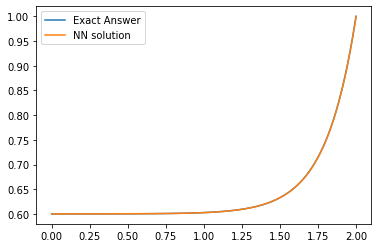

In [29]:
plt.plot(t, Exact_u)
plt.plot(t, u_pred)
plt.legend(['Exact Answer', 'NN solution'])
plt.show()

In [12]:
# test = [0.9]
# test = np.reshape(test, (-1, 1))
# pinn.predict(test)

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.6003282]], dtype=float32)>,
 <tf.Tensor: shape=(500, 1), dtype=float32, numpy=
 array([[-6.19411469e-04],
        [ 1.51395798e-04],
        [ 7.41720200e-04],
        [-5.86748123e-04],
        [-3.90529633e-04],
        [-2.14815140e-04],
        [-6.20365143e-04],
        [-5.57899475e-04],
        [-6.04629517e-04],
        [ 1.18565559e-03],
        [-5.95092773e-04],
        [-3.70979309e-04],
        [-3.62396240e-04],
        [ 1.27625465e-03],
        [ 9.41753387e-05],
        [-4.87565994e-04],
        [ 1.91712379e-03],
        [ 6.08921051e-04],
        [-4.41312790e-04],
        [ 1.78551674e-03],
        [-5.68628311e-04],
        [-5.14984131e-04],
        [-2.05278397e-04],
        [ 1.01566315e-04],
        [-5.69820404e-05],
        [-4.01735306e-04],
        [-6.20603561e-04],
        [-6.20126724e-04],
        [-6.06298447e-04],
        [-3.44753265e-04],
        [ 9.90390778e-04],
        [ 8.28027725e-04],